# Analysis of Pre-processed Feature Statistics

**Project:** Long-Tail Offline RL

**Objective:** To load the `feature_stats.npz` file and visualize the calculated mean and standard deviation for our key feature tensors. This serves as a critical sanity check to ensure our data pipeline is producing sensible, well-scaled features before we begin training the scout ensemble and the final CQL agents.

In [2]:
# ## 1. Setup and Configuration
# 
# Load necessary libraries and the project configuration to get the correct file paths.

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path to allow importing project modules
# This assumes the notebook is in the `notebooks/` directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.utils.config import load_config
# The FeatureExtractor is now in the 'rl' module
from src.rl.feature_extractor import FeatureExtractor

# Load project config
config = load_config(config_path='../configs/main_config.yaml')

# Set plot style
sns.set_theme(style="whitegrid")

Configuration loaded successfully.


In [3]:
# ## 2. Load the Statistics File
# 
# Load the `mean` and `std` arrays from the `.npz` file generated by `compute_feature_stats.py`.

# +
stats_path = config['data']['feature_stats_path']

if not os.path.exists(stats_path):
    raise FileNotFoundError(f"Statistics file not found at: {stats_path}\n"
                            "Please run `src/data_processing/compute_feature_stats.py` first.")

stats = np.load(stats_path)
print("Successfully loaded statistics file. Available keys:")
print(list(stats.keys()))

Successfully loaded statistics file. Available keys:
['agents_mean', 'agents_std', 'map_mean', 'map_std', 'traffic_lights_mean', 'traffic_lights_std', 'ego_map_mean', 'ego_map_std']


FeatureExtractor initialized.


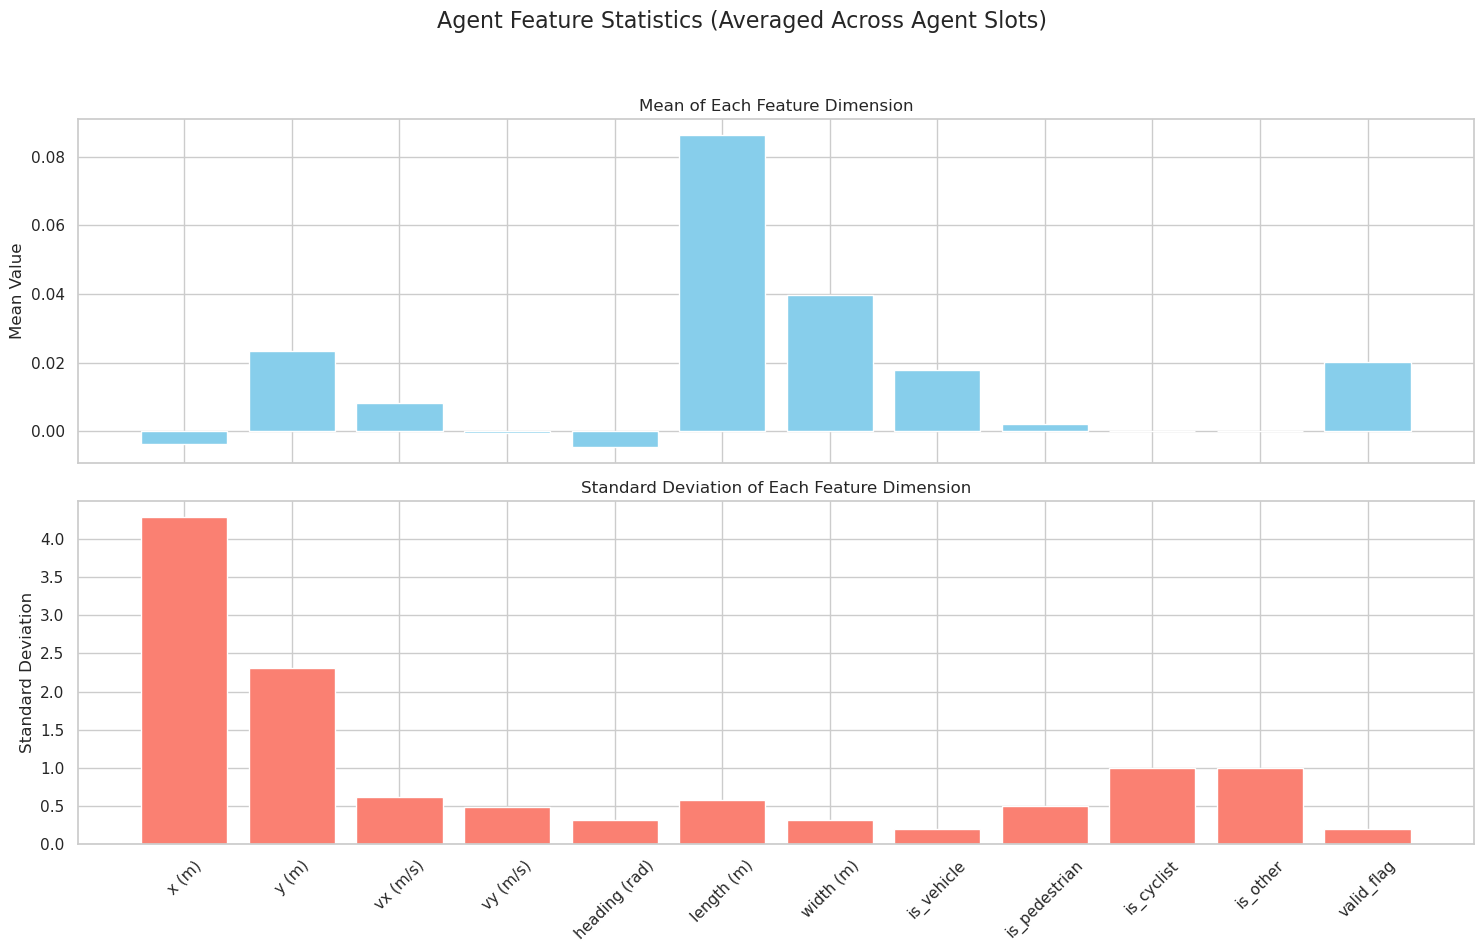

--- Sanity Check ---
Mean of relative x position: -0.00 m (Should be positive, as agents are mostly in front)
Mean of relative y position: 0.02 m (Should be close to zero, indicating no left/right bias)
Mean of 'is_vehicle' flag: 0.02 (Indicates the proportion of valid agents that are vehicles)
Std dev of positions is high: 4.28 m (Good, shows diverse agent locations)


In [8]:
# ## 3. Analyze Agent Features
# 
# Let's visualize the statistics for the `agents` feature tensor. This tensor has a shape of `(num_agents, 12)`. We will plot the mean and standard deviation for each of the 12 feature dimensions, averaged across all `num_agents` slots.

# +
# Instantiate a FeatureExtractor just to get the list of categories for labeling
# This also confirms the FeatureExtractor can be initialized successfully.
feature_extractor = FeatureExtractor(config)

agent_mean = stats['agents_mean']
agent_std = stats['agents_std']

# Define the labels for the 12 agent features for clear plotting
agent_feature_labels = [
    'x (m)', 'y (m)', 'vx (m/s)', 'vy (m/s)', 'heading (rad)', 
    'length (m)', 'width (m)', 
    'is_vehicle', 'is_pedestrian', 'is_cyclist', 'is_other', 
    'valid_flag'
]

# Average the stats across the 'num_agents' dimension for a summary plot
avg_agent_mean = np.mean(agent_mean, axis=0)
avg_agent_std = np.mean(agent_std, axis=0)

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
fig.suptitle('Agent Feature Statistics (Averaged Across Agent Slots)', fontsize=16)

# Plot Mean
axes[0].bar(agent_feature_labels, avg_agent_mean, color='skyblue')
axes[0].set_title('Mean of Each Feature Dimension')
axes[0].set_ylabel('Mean Value')
axes[0].tick_params(axis='x', rotation=45)

# Plot Standard Deviation
axes[1].bar(agent_feature_labels, avg_agent_std, color='salmon')
axes[1].set_title('Standard Deviation of Each Feature Dimension')
axes[1].set_ylabel('Standard Deviation')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("--- Sanity Check ---")
print(f"Mean of relative x position: {avg_agent_mean[0]:.2f} m (Should be positive, as agents are mostly in front)")
print(f"Mean of relative y position: {avg_agent_mean[1]:.2f} m (Should be close to zero, indicating no left/right bias)")
print(f"Mean of 'is_vehicle' flag: {avg_agent_mean[7]:.2f} (Indicates the proportion of valid agents that are vehicles)")
print(f"Std dev of positions is high: {avg_agent_std[0]:.2f} m (Good, shows diverse agent locations)")

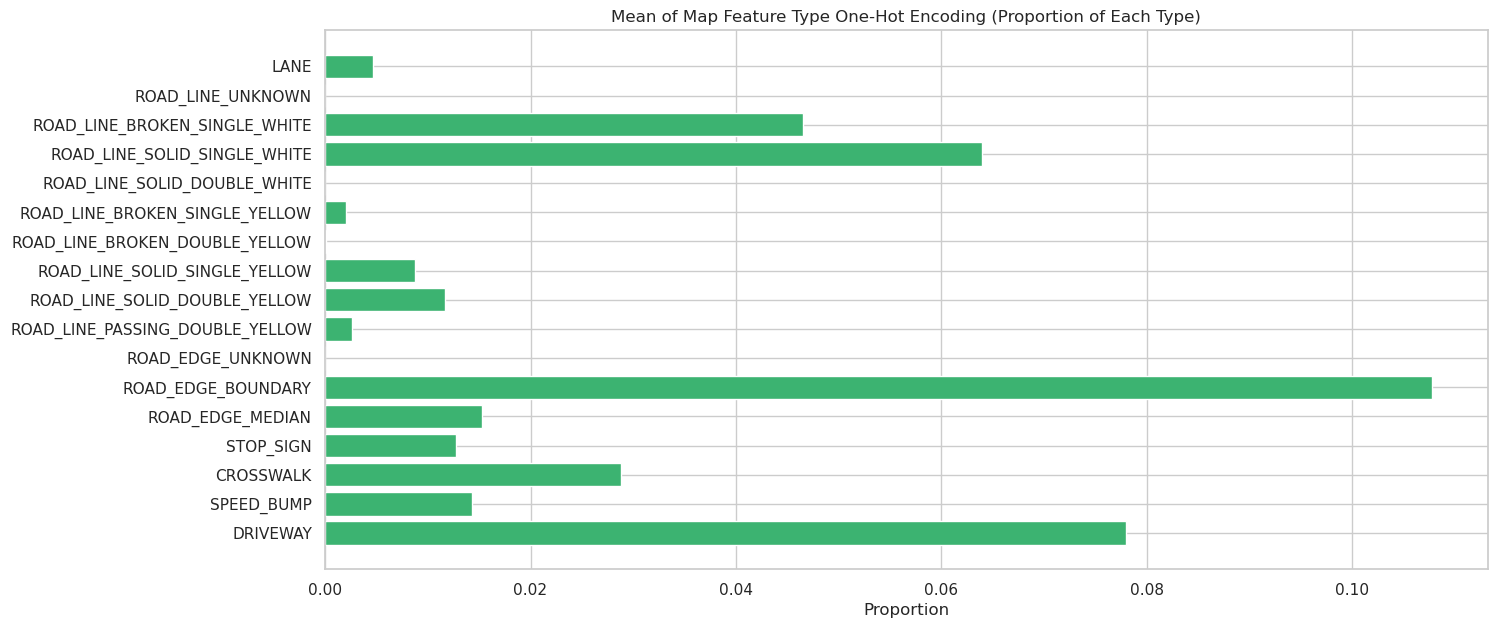

--- Sanity Check ---
The most common map feature type is 'ROAD_EDGE_BOUNDARY' with a proportion of 0.108
(This is expected to be LANE or a common road line type)


In [9]:
# ## 4. Analyze Map and Traffic Light Features
# 
# We will visualize the mean value of the one-hot encoded map feature types to see which are most common in our dataset.

# +
map_mean = stats['map_mean']
map_std = stats['map_std']

# Extract the one-hot encoded part of the map features
pts_per_polyline = config['features']['map_points_per_polyline']
num_coord_features = pts_per_polyline * 2
num_type_features = feature_extractor.num_map_feature_categories
type_features_start_idx = num_coord_features
type_features_end_idx = num_coord_features + num_type_features

# Average across the 'num_map_polylines' dimension
avg_type_mean = np.mean(map_mean[:, type_features_start_idx:type_features_end_idx], axis=0)
map_type_labels = feature_extractor.map_feature_categories

fig, ax = plt.subplots(figsize=(15, 7))
ax.barh(map_type_labels, avg_type_mean, color='mediumseagreen') # Horizontal bar plot for readability
ax.set_title('Mean of Map Feature Type One-Hot Encoding (Proportion of Each Type)')
ax.set_xlabel('Proportion')
ax.invert_yaxis() # Display most common at the top
plt.show()

print("--- Sanity Check ---")
print(f"The most common map feature type is '{map_type_labels[np.argmax(avg_type_mean)]}' "
      f"with a proportion of {np.max(avg_type_mean):.3f}")
print("(This is expected to be LANE or a common road line type)")

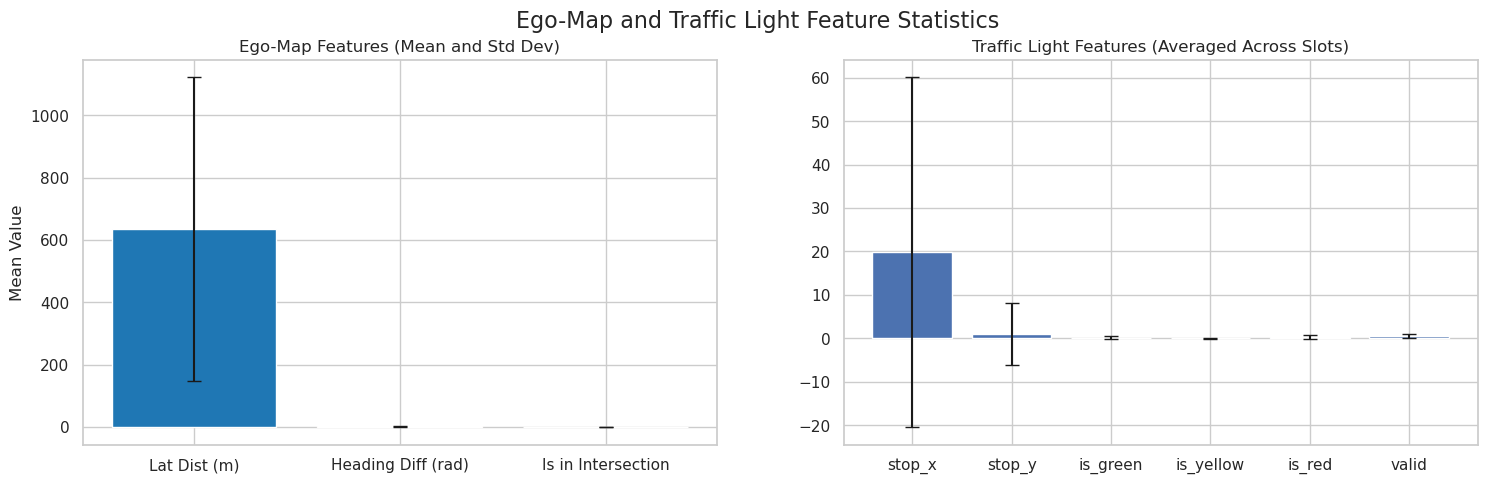

--- Sanity Check ---
Mean Lateral Distance: 635.23 m (Should be close to zero, indicating SDC is usually centered)
Mean Heading Difference: 1.94 rad (Should be close to zero, indicating SDC follows lanes)
Proportion of time in intersection: 13.27%


In [10]:
# ## 5. Analyze Ego-Map and Traffic Light Features

ego_map_mean = stats['ego_map_mean']
ego_map_std = stats['ego_map_std']
tl_mean = stats['traffic_lights_mean']
tl_std = stats['traffic_lights_std']

ego_feature_labels = ['Lat Dist (m)', 'Heading Diff (rad)', 'Is in Intersection']
avg_tl_mean = np.mean(tl_mean, axis=0)
tl_feature_labels = ['stop_x', 'stop_y', 'is_green', 'is_yellow', 'is_red', 'valid']

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle('Ego-Map and Traffic Light Feature Statistics', fontsize=16)

# Ego-Map Stats
axes[0].bar(ego_feature_labels, ego_map_mean, yerr=ego_map_std, capsize=5, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_title('Ego-Map Features (Mean and Std Dev)')
axes[0].set_ylabel('Mean Value')

# Traffic Light Stats
axes[1].bar(tl_feature_labels, avg_tl_mean, yerr=np.mean(tl_std, axis=0), capsize=5)
axes[1].set_title('Traffic Light Features (Averaged Across Slots)')

plt.show()

print("--- Sanity Check ---")
print(f"Mean Lateral Distance: {ego_map_mean[0]:.2f} m (Should be close to zero, indicating SDC is usually centered)")
print(f"Mean Heading Difference: {ego_map_mean[1]:.2f} rad (Should be close to zero, indicating SDC follows lanes)")
print(f"Proportion of time in intersection: {ego_map_mean[2]:.2%}")